In [1]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import CVRPEnv, CVRPTWEnv
from rl4co.models.nn.utils import rollout, random_policy
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

In [10]:
env = CVRPTWEnv(
    num_loc=30,
    min_loc=0,
    max_loc=20,
    min_demand=1,
    max_demand=10,
    vehicle_capacity=1,
    min_time=0,
    max_time=480,
    scale = False
)

Start rollout...
Done.
Finished run with reward:
 tensor([-407.4418, -445.6206, -376.3047]) 
actions:
 tensor([[ 8, 18,  7, 10, 24, 27, 25, 30, 21,  0, 11,  0,  2,  9, 15,  5, 13,  0,
          6, 12, 16, 14,  4,  0, 28, 23, 22,  0, 29, 20, 19, 17,  0, 26,  3,  1,
          0,  0],
        [ 2,  0,  8, 10, 28, 24, 15,  0, 21,  6,  5, 11, 23, 29,  0, 18, 16, 19,
          3, 17,  0, 25, 13, 14, 30,  0, 12, 26,  0, 20,  7, 22,  0, 27,  4,  9,
          0,  1],
        [21, 28, 14, 29,  0,  3,  4,  8, 10,  0, 20, 30,  2, 24, 17, 22, 15,  0,
         13, 19,  7, 12, 25, 26,  0,  1,  5, 18, 23,  6,  9,  0, 16, 11, 27,  0,
          0,  0]])


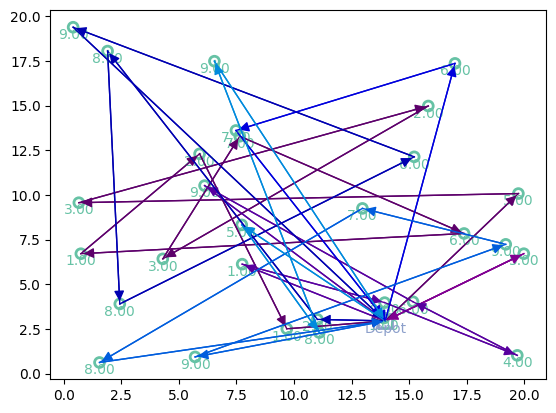

In [13]:
# try random policy with a random instance
batch_size = 3

print("Start rollout...")
reward, td, actions = rollout(
    env=env, td=env.reset(batch_size=[batch_size]), policy=random_policy, max_steps=100
)
print("Done.")
print("Finished run with reward:\n", reward, "\nactions:\n", actions)
env.render(td, actions)

Start attention model...


/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Tour lengths: ['290.03', '359.78', '414.60']


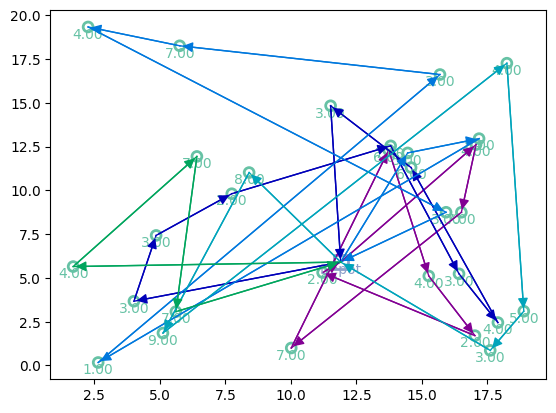

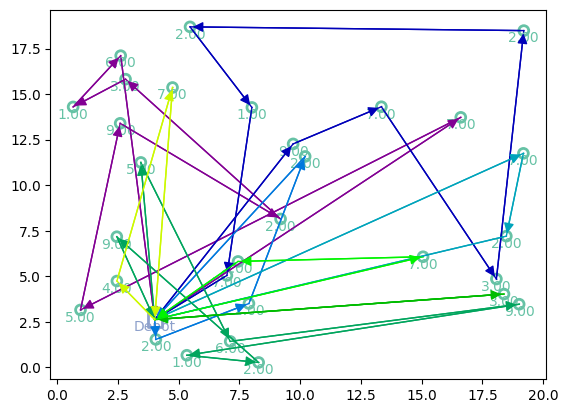

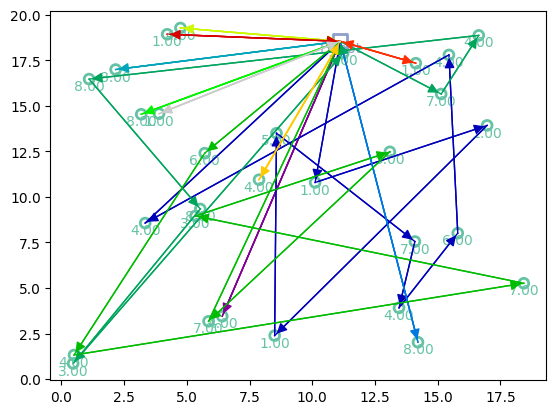

In [12]:
# Model: default is AM with REINFORCE and greedy rollout baseline
print("Start attention model...")
model = AttentionModel(
    env, baseline="rollout", train_data_size=100_000, val_data_size=10_000
)

# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out["actions"].cpu()):
    env.render(td, actions)